
# 13: Principal Component Analysis (PCA)




## 1. Setup


In [4]:

import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)

def standardize(X, with_mean=True, with_std=True):
    X = np.asarray(X, dtype=float)
    mean_ = X.mean(axis=0) if with_mean else np.zeros(X.shape[1])
    Xc = X - mean_
    if with_std:
        std_ = Xc.std(axis=0, ddof=1)
        std_[std_ == 0.0] = 1.0
        Xn = Xc / std_
    else:
        std_ = np.ones(X.shape[1])
        Xn = Xc
    return Xn, mean_, std_



## 2. PCA Intuition

PCA finds orthogonal directions (principal components) that maximize variance and decorrelate features.
Two equivalent views:
1. **Covariance eigen**: eigenvectors of the sample covariance are principal axes; eigenvalues are variances.
2. **SVD**: for centered $X\in\mathbb{R}^{n\times d}$, SVD $X=U\Sigma V^\top$ gives principal directions $V$ and variances $\sigma_i^2/(n-1)$.



## 3. PCA from Scratch (SVD-based)


In [2]:

class PCA_SVD:
    def __init__(self, n_components=None, center=True, scale=False, whiten=False):
        self.n_components = n_components
        self.center = center
        self.scale = scale
        self.whiten = whiten
        self.mean_ = None
        self.scale_ = None
        self.components_ = None
        self.singular_values_ = None
        self.explained_variance_ = None
        self.explained_variance_ratio_ = None

    def fit(self, X):
        X = np.asarray(X, dtype=float)
        if self.center or self.scale:
            Xn, mean_, scale_ = standardize(X, with_mean=self.center, with_std=self.scale)
        else:
            Xn, mean_, scale_ = X.copy(), np.zeros(X.shape[1]), np.ones(X.shape[1])

        n, d = Xn.shape
        U, S, Vt = np.linalg.svd(Xn, full_matrices=False)
        ev = (S**2) / max(n - 1, 1)
        total_var = ev.sum()
        ratio = ev / (total_var + 1e-16)

        self.mean_ = mean_
        self.scale_ = scale_
        self.components_ = Vt  # rows are axes
        self.singular_values_ = S
        self.explained_variance_ = ev
        self.explained_variance_ratio_ = ratio
        return self

    def transform(self, X, k=None):
        if k is None:
            k = self.n_components if self.n_components is not None else X.shape[1]
        Xc = (X - self.mean_) / self.scale_
        V = self.components_[:k].T
        Z = Xc @ V
        if self.whiten:
            S = self.singular_values_[:k]
            S[S == 0.0] = 1.0
            Z = Z / S
        return Z

    def inverse_transform(self, Z):
        k = Z.shape[1]
        V = self.components_[:k].T
        if self.whiten:
            S = self.singular_values_[:k]
            Xc = (Z * S) @ V.T
        else:
            Xc = Z @ V.T
        X = Xc * self.scale_ + self.mean_
        return X



## 4. 2D Correlated Data Example


Explained variance ratio (2D): [0.9516 0.0484]
Components (rows):
 [[ 0.7831  0.6219]
 [-0.6219  0.7831]]


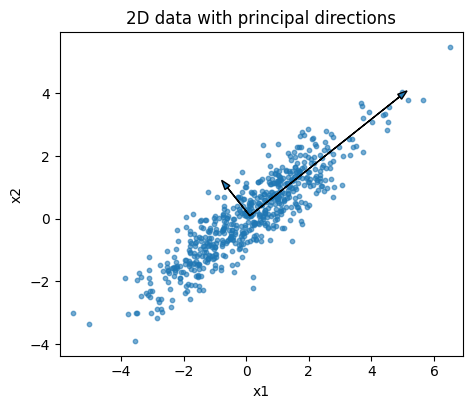

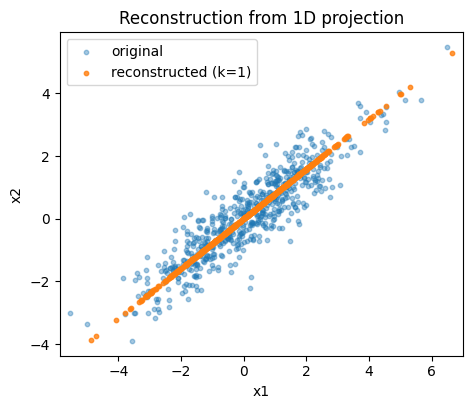

In [10]:

# 2D correlated Gaussian data
n = 600
mean = np.array([0.0, 0.0])
cov = np.array([[3.0, 2.2],
                [2.2, 2.0]])
X2 = rng.multivariate_normal(mean, cov, size=n)

pca2 = PCA_SVD(center=True, scale=False).fit(X2)
print("Explained variance ratio (2D):", np.round(pca2.explained_variance_ratio_[:2], 4))
print("Components (rows):\n", np.round(pca2.components_[:2], 4))

# Plot data and principal axes
vals = pca2.explained_variance_[:2]
vecs = pca2.components_[:2]
origin = pca2.mean_

plt.figure(figsize=(5.2, 4.2))
plt.scatter(X2[:,0], X2[:,1], s=10, alpha=0.6)
scale = np.sqrt(vals)
for i in range(2):
    v = vecs[i]
    tip = origin + v * scale[i] * 3.0
    plt.arrow(origin[0], origin[1], tip[0]-origin[0], tip[1]-origin[1],
              head_width=0.2, length_includes_head=True)
plt.title("2D data with principal directions")
plt.xlabel("x1"); plt.ylabel("x2")
plt.axis("equal")
plt.show()

# Project to 1D and reconstruct
Z1 = pca2.transform(X2, k=1)
X2_recon_1d = pca2.inverse_transform(Z1)

plt.figure(figsize=(5.2, 4.2))
plt.scatter(X2[:,0], X2[:,1], s=10, alpha=0.4, label="original")
plt.scatter(X2_recon_1d[:,0], X2_recon_1d[:,1], s=10, alpha=0.8, label="reconstructed (k=1)")
plt.title("Reconstruction from 1D projection")
plt.xlabel("x1"); plt.ylabel("x2")
plt.legend()
plt.axis("equal")
plt.show()



## 5. Scree Plot & Cumulative Explained Variance


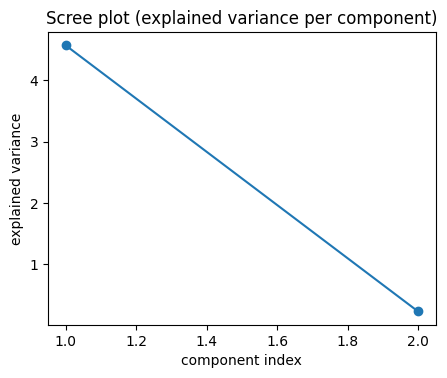

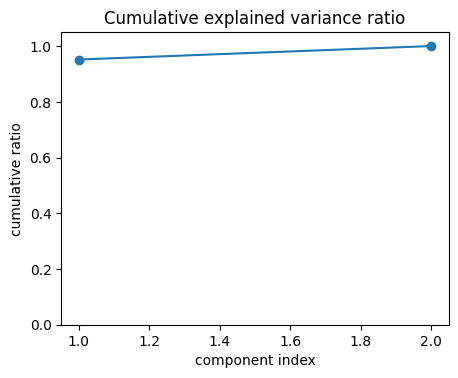

In [11]:

ev = pca2.explained_variance_
evr = pca2.explained_variance_ratio_
cev = np.cumsum(evr)

plt.figure(figsize=(5, 3.8))
plt.plot(np.arange(1, len(ev)+1), ev, marker="o")
plt.title("Scree plot (explained variance per component)")
plt.xlabel("component index"); plt.ylabel("explained variance")
plt.show()

plt.figure(figsize=(5, 3.8))
plt.plot(np.arange(1, len(cev)+1), cev, marker="o")
plt.ylim(0, 1.05)
plt.title("Cumulative explained variance ratio")
plt.xlabel("component index"); plt.ylabel("cumulative ratio")
plt.show()



## 6. PCA with scikit-learn


In [11]:

try:
    from sklearn.decomposition import PCA as SKPCA

    skp = SKPCA(n_components=3, svd_solver="full")
    skp.fit(X3 - X3.mean(axis=0))
    print("Our PCA evr (first 3):", np.round(pca3.explained_variance_ratio_[:3], 4))
    print("SKLearn  evr (first 3):", np.round(skp.explained_variance_ratio_[:3], 4))
except Exception as e:
    print("scikit-learn not available or failed:", e)


scikit-learn not available or failed: name 'X3' is not defined



## 7. Image Reconstruction with PCA

We demonstrate image reconstruction using PCA on the **scikit-learn digits** dataset (64×64 grayscale images).
We'll fit PCA to the training images and reconstruct a sample image using a small number of components.


In [ ]:
# Image reconstruction with PCA using scikit-learn's Olivetti faces dataset
try:
    from sklearn.datasets import fetch_olivetti_faces
    data = fetch_olivetti_faces()
    X = data.data.astype(float)  # shape: (n_samples, 4096), flattened 64x64 images
    images = data.images  # (n_samples, 64, 64)
    n_samples, n_features = X.shape
    print(f"Loaded Olivetti faces: {n_samples} samples, {n_features} features (64x64 images).")
except Exception as e:
    print("Failed to load sklearn Olivetti faces dataset:", e)
    raise SystemExit(0)


# Fit PCA on all face images (centered, not scaled)
pca_img = PCA_SVD(center=True, scale=False).fit(X)

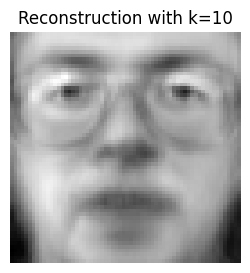

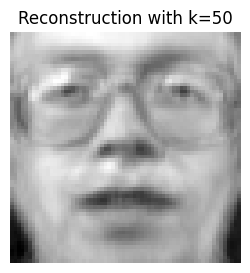

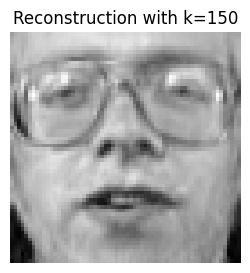

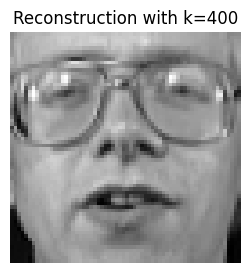

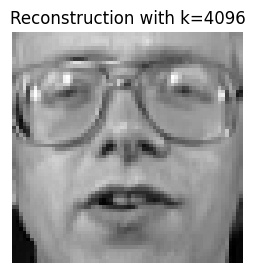

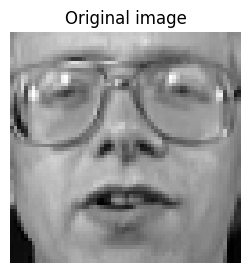

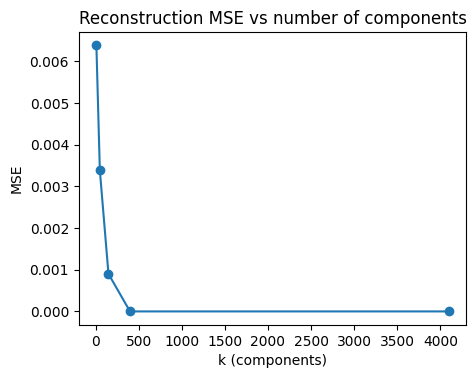

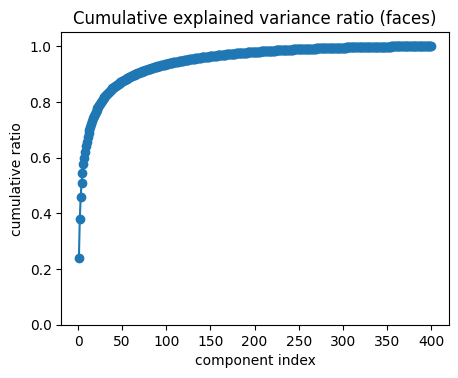

In [10]:
# Choose a sample image to reconstruct
idx = 10  # feel free to change to any index < n_samples
x = X[idx:idx+1]  # shape (1, 4096)
orig = images[idx]

# Reconstruct with different numbers of components
k_list = [10, 50, 150, 400, n_features]  # n_features is the full reconstruction
mses = []
for k in k_list:
    Zk = pca_img.transform(x, k=k)
    xr = pca_img.inverse_transform(Zk)[0].reshape(64,64)
    mse = np.mean((orig - xr)**2)
    mses.append(mse)

    # Display reconstruction (one figure per reconstruction to avoid subplots)
    plt.figure(figsize=(3,3))
    plt.imshow(xr, cmap="gray")
    plt.title(f"Reconstruction with k={k}")
    plt.axis("off")
    plt.show()

# Show original image separately
plt.figure(figsize=(3,3))
plt.imshow(orig, cmap="gray")
plt.title("Original image")
plt.axis("off")
plt.show()

# Plot MSE vs k
plt.figure(figsize=(5,3.8))
plt.plot(k_list, mses, marker="o")
plt.title("Reconstruction MSE vs number of components")
plt.xlabel("k (components)")
plt.ylabel("MSE")
plt.show()

# Plot cumulative explained variance ratio (useful to relate k to retained variance)
cev = np.cumsum(pca_img.explained_variance_ratio_)
plt.figure(figsize=(5,3.8))
plt.plot(np.arange(1, len(cev)+1), cev, marker="o")
plt.ylim(0, 1.05)
plt.title("Cumulative explained variance ratio (faces)")
plt.xlabel("component index")
plt.ylabel("cumulative ratio")
plt.show()

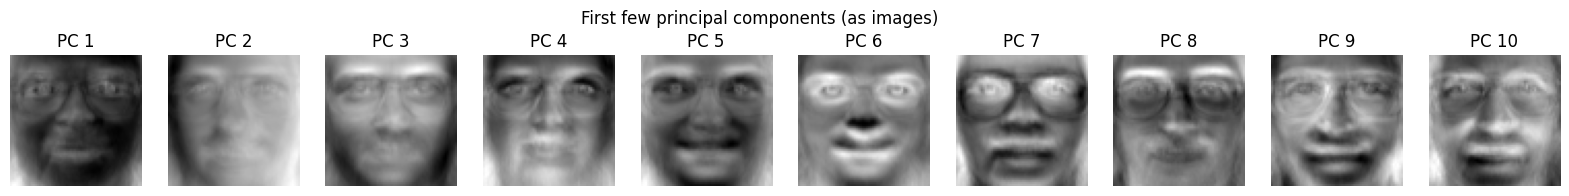

In [7]:
# Plot the first few principal components as images
n_components_to_plot = 10  # You can change this number
components = pca_img.components_[:n_components_to_plot]

plt.figure(figsize=(2*n_components_to_plot, 2))
for i in range(n_components_to_plot):
    comp = components[i].reshape(64, 64)
    plt.subplot(1, n_components_to_plot, i + 1)
    plt.imshow(comp, cmap="gray")
    plt.title(f"PC {i+1}")
    plt.axis("off")
plt.suptitle("First few principal components (as images)", y=1.05)
plt.show()


## 8. Conclusion

You learned PCA intuition, its SVD connection, and implemented a practical PCA pipeline from scratch.
